# Tweet Emotion Recognition: Natural Language Processing with TensorFlow


## 1: Setup and Imports


In [7]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, len(classes))), labels=classes)
    plt.yticks(list(range(0, len(classes))), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.3.0


## 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [8]:
!pip install nlp
import nlp
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [9]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [10]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [11]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [12]:
tweets_train, labels_train = get_tweet(train)

In [13]:
tweets_train[1:4], labels_train[1:4]

(['i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property'],
 ['sadness', 'anger', 'love'])

## 4: Tokenizer

Tokenizing the tweets, it is a text preprocessing module represents words as numbers

In [14]:
from keras.preprocessing.text import Tokenizer

In [15]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')  # any word not in vocablury is represented by oov_token
tokenizer.fit_on_texts(tweets_train)

In [16]:
tokenizer.texts_to_sequences([tweets_train[0]])

[[2, 139, 3, 679]]

In [17]:
tweets_train[0]

'i didnt feel humiliated'

## 5: Padding and Truncating Sequences
padding is requires as the model wants input of same length

1. Checking length of the tweets
2. Creating padded sequences

truncating if sentence longer then maxlen
then the ending will truncated means will not be included in list

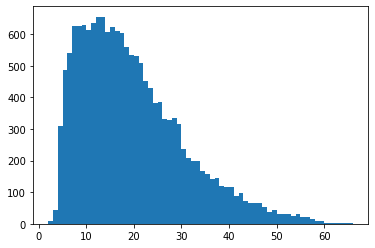

In [18]:
lengths = [len(t.split()) for t in tweets_train]
plt.hist(lengths, bins=len(set(lengths)))
plt.show() 

In [19]:
maxlen = 50
from keras.preprocessing.sequence import pad_sequences

def get_seq(tokenizer, tweets, maxlen):
  seq = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(seq, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [20]:
train_padded = get_seq(tokenizer, tweets_train, maxlen)

In [21]:
train_padded[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [22]:
set(labels_train)

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

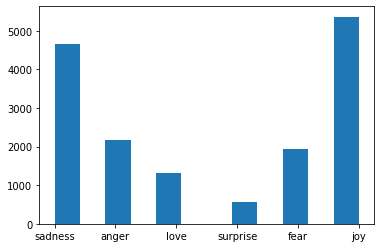

In [23]:
plt.hist(labels_train, bins=12)
plt.show()

In [24]:
class_to_index = dict((c,i) for i, c in enumerate(set(labels_train)))
index_to_class = dict((v,k) for k, v in class_to_index.items())

In [25]:
class_to_index

{'anger': 5, 'fear': 0, 'joy': 1, 'love': 2, 'sadness': 4, 'surprise': 3}

In [26]:
index_to_class

{0: 'fear', 1: 'joy', 2: 'love', 3: 'surprise', 4: 'sadness', 5: 'anger'}

In [27]:
get_labels_ids = lambda labels: np.array([class_to_index[x] for x in labels])

In [28]:
train_labels = get_labels_ids(labels_train)
print(train_labels[0])

4


## 7: Creating the Model

1. Creating the model
2. Compiling the model

In [29]:
from keras.layers import Embedding, Bidirectional, LSTM, Dense

model = tf.keras.models.Sequential([Embedding(10000, 16, input_length=maxlen),
                                    Bidirectional(LSTM(20, return_sequences=True)),
                                    Bidirectional(LSTM(20)),
                                    Dense(6, activation='softmax')
                                  ])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## 8: Training the Model

1. Preparing a validation set
2. Training the model

In [30]:
val_tweets, val_labels = get_tweet(val)
val_padded = get_seq(tokenizer, val_tweets, maxlen)
val_labels = get_labels_ids(val_labels)

In [31]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 4)

In [32]:
h = model.fit(train_padded, train_labels,
              validation_data=(val_padded, val_labels),
              epochs=25)

Epoch 1/25
500/500 [==============================] - 8s 17ms/step - loss: 1.2928 - accuracy: 0.4955 - val_loss: 0.7965 - val_accuracy: 0.7135
Epoch 2/25
500/500 [==============================] - 7s 14ms/step - loss: 0.5548 - accuracy: 0.8055 - val_loss: 0.5498 - val_accuracy: 0.8195
Epoch 3/25
500/500 [==============================] - 7s 14ms/step - loss: 0.3337 - accuracy: 0.8921 - val_loss: 0.4734 - val_accuracy: 0.8380
Epoch 4/25
500/500 [==============================] - 8s 15ms/step - loss: 0.2277 - accuracy: 0.9291 - val_loss: 0.4727 - val_accuracy: 0.8440
Epoch 5/25
500/500 [==============================] - 8s 15ms/step - loss: 0.1657 - accuracy: 0.9486 - val_loss: 0.4215 - val_accuracy: 0.8645
Epoch 6/25
500/500 [==============================] - 7s 14ms/step - loss: 0.1226 - accuracy: 0.9631 - val_loss: 0.4206 - val_accuracy: 0.8710
Epoch 7/25
500/500 [==============================] - 7s 14ms/step - loss: 0.0991 - accuracy: 0.9703 - val_loss: 0.4652 - val_accuracy: 0.8690

## 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

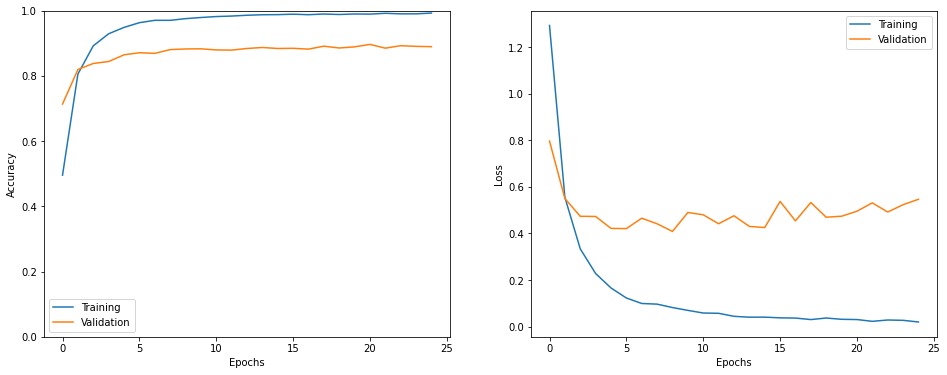

In [33]:
show_history(h)

In [34]:
test_tweets, test_labels = get_tweet(test)
test_padded = get_seq(tokenizer, test_tweets, maxlen)
test_labels = get_labels_ids(test_labels)

In [35]:
model.evaluate(test_padded, test_labels)

63/63 [==============================] - 0s 6ms/step - loss: 0.5134 - accuracy: 0.8925


[0.5134133100509644, 0.8924999833106995]

In [40]:
import random
i = random.randint(0, len(test_labels)-1)

print('Sentence 1:', test_tweets[i])
print('org emotion 1:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_padded[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion 1 :', pred_class)
i = random.randint(0, len(test_labels)-1)

print('Sentence 2:', test_tweets[i])
print('org emotion 2:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_padded[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion 2:', pred_class)

Sentence 1: i just keep feeling like someone is being unkind to me and doing me wrong and then all i can think of doing is to get back at them and the people they are close to
org emotion 1: anger
Predicted Emotion 1 : anger
Sentence 2: i do take on a half marathon challenge then i will wait and see how the body feels as to whether there will be a pb attempt or a casual kilometre shuffle
org emotion 2: joy
Predicted Emotion 2: joy


In [37]:
preds = model.predict(test_padded)
preds = np.argmax(preds, axis=-1)

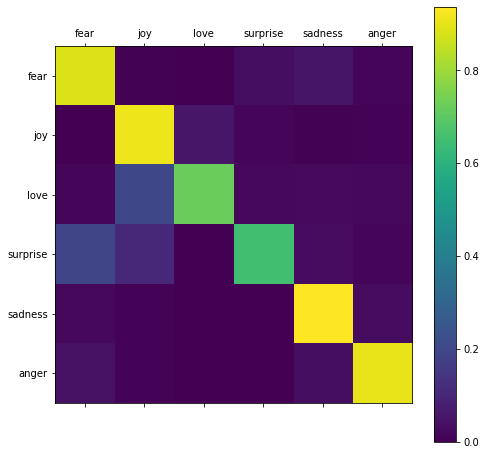

In [38]:
show_confusion_matrix(test_labels, preds, list(set(labels_train)))